## Tides and elevation analysis

In [3]:
#General libraries DEM Bathymetry
import geopandas as gpd
import matplotlib.pyplot as plt
import contextily as ctx
import matplotlib.patheffects as pe
import os
import rasterio
import numpy as np
import matplotlib.pyplot as plt

#General libraries HEC-RAS
import h5py
import pandas as pd
from shapely.geometry import Point
from scipy.spatial import cKDTree
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import math
import matplotlib.dates as mdates


## Cross Sections locations

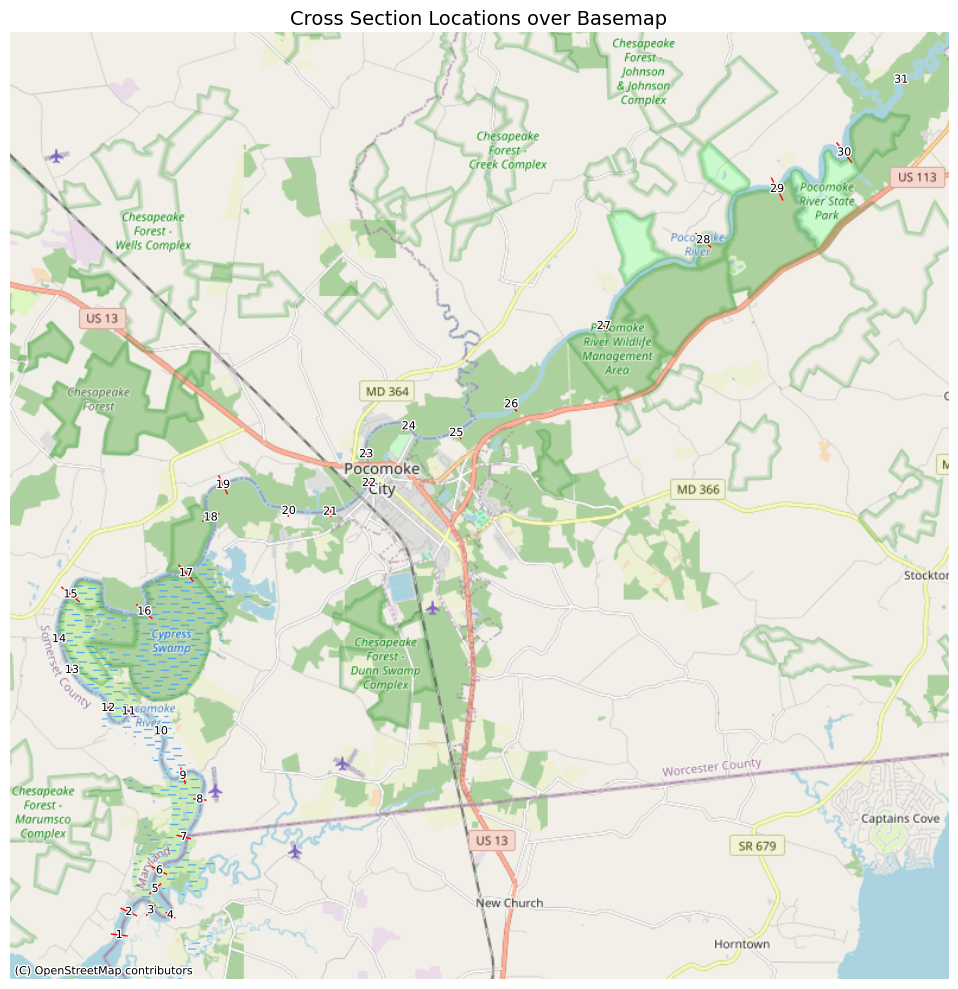

In [140]:
#Load your shapefile
lines_gdf = gpd.read_file(r"C:\Github\Lab_work\Pocomoke\POCOMOKE_DEM\Cross.shp")

#Convert to Web Mercator (required for basemap tiles)
lines_gdf = lines_gdf.to_crs(epsg=3857)

#Plot
fig, ax = plt.subplots(figsize=(12, 10))
lines_gdf.plot(ax=ax, edgecolor='red', linewidth=1)

# Label each cross-section
for idx, row in lines_gdf.iterrows():
    x, y = row.geometry.centroid.x, row.geometry.centroid.y
    ax.text(x, y, str(idx + 1), fontsize=8, ha='center', va='center',
            path_effects=[pe.withStroke(linewidth=2, foreground='white')])

# Add basemap (OpenStreetMap by default)
ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik)

# Format
ax.set_title("Cross Section Locations over Basemap", fontsize=14)
ax.set_axis_off()
plt.tight_layout()
plt.show()


## Carving channel 
NOTE:

    #BC data: total water level.
    #Gauge to compare: tides only.
    #I changed the polygon channel in this simulation.
    

#Boundary Condition data
(USGS Starling)


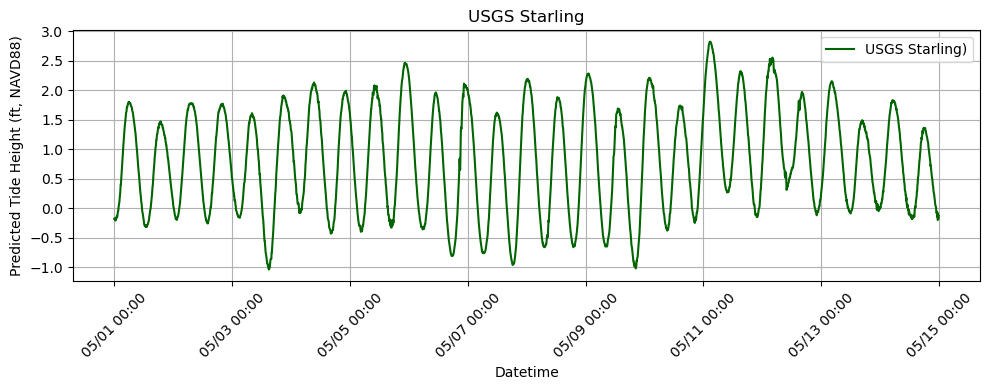

In [ ]:
#Gauge plot -#Starling gauge data - BC
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# === File path ===
excel_path = r"C:\Github\Lab_work\Pocomoke\POCOMOKE_DEM\Depth_2024\USGS_gage.xlsx"

# === Load Sheet2
df = pd.read_excel(excel_path, sheet_name="Sheet2")

# === Clean column names and rename
df.columns = df.columns.str.strip().str.replace('\n', ' ', regex=True)
df.rename(columns={
    df.columns[0]: "Datetime",
    df.columns[1]: "Water Level (ft)",
}, inplace=True)

# === Plot with full datetime labels
plt.figure(figsize=(10, 4))
plt.plot(df["Datetime"], df["Water Level (ft)"], label="USGS Starling)", color='darkgreen')
plt.title("USGS Starling")
plt.xlabel("Datetime")
plt.ylabel("Predicted Tide Height (ft, NAVD88)")
plt.grid(True)

# Format x-axis to show both date and time
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%m/%d %H:%M'))
plt.xticks(rotation=45)

plt.tight_layout()
plt.legend()
plt.show()

## Test 7.2
#v5p83

#Results for 31 cross sections using channel 50ft + different river polygon + different computation times

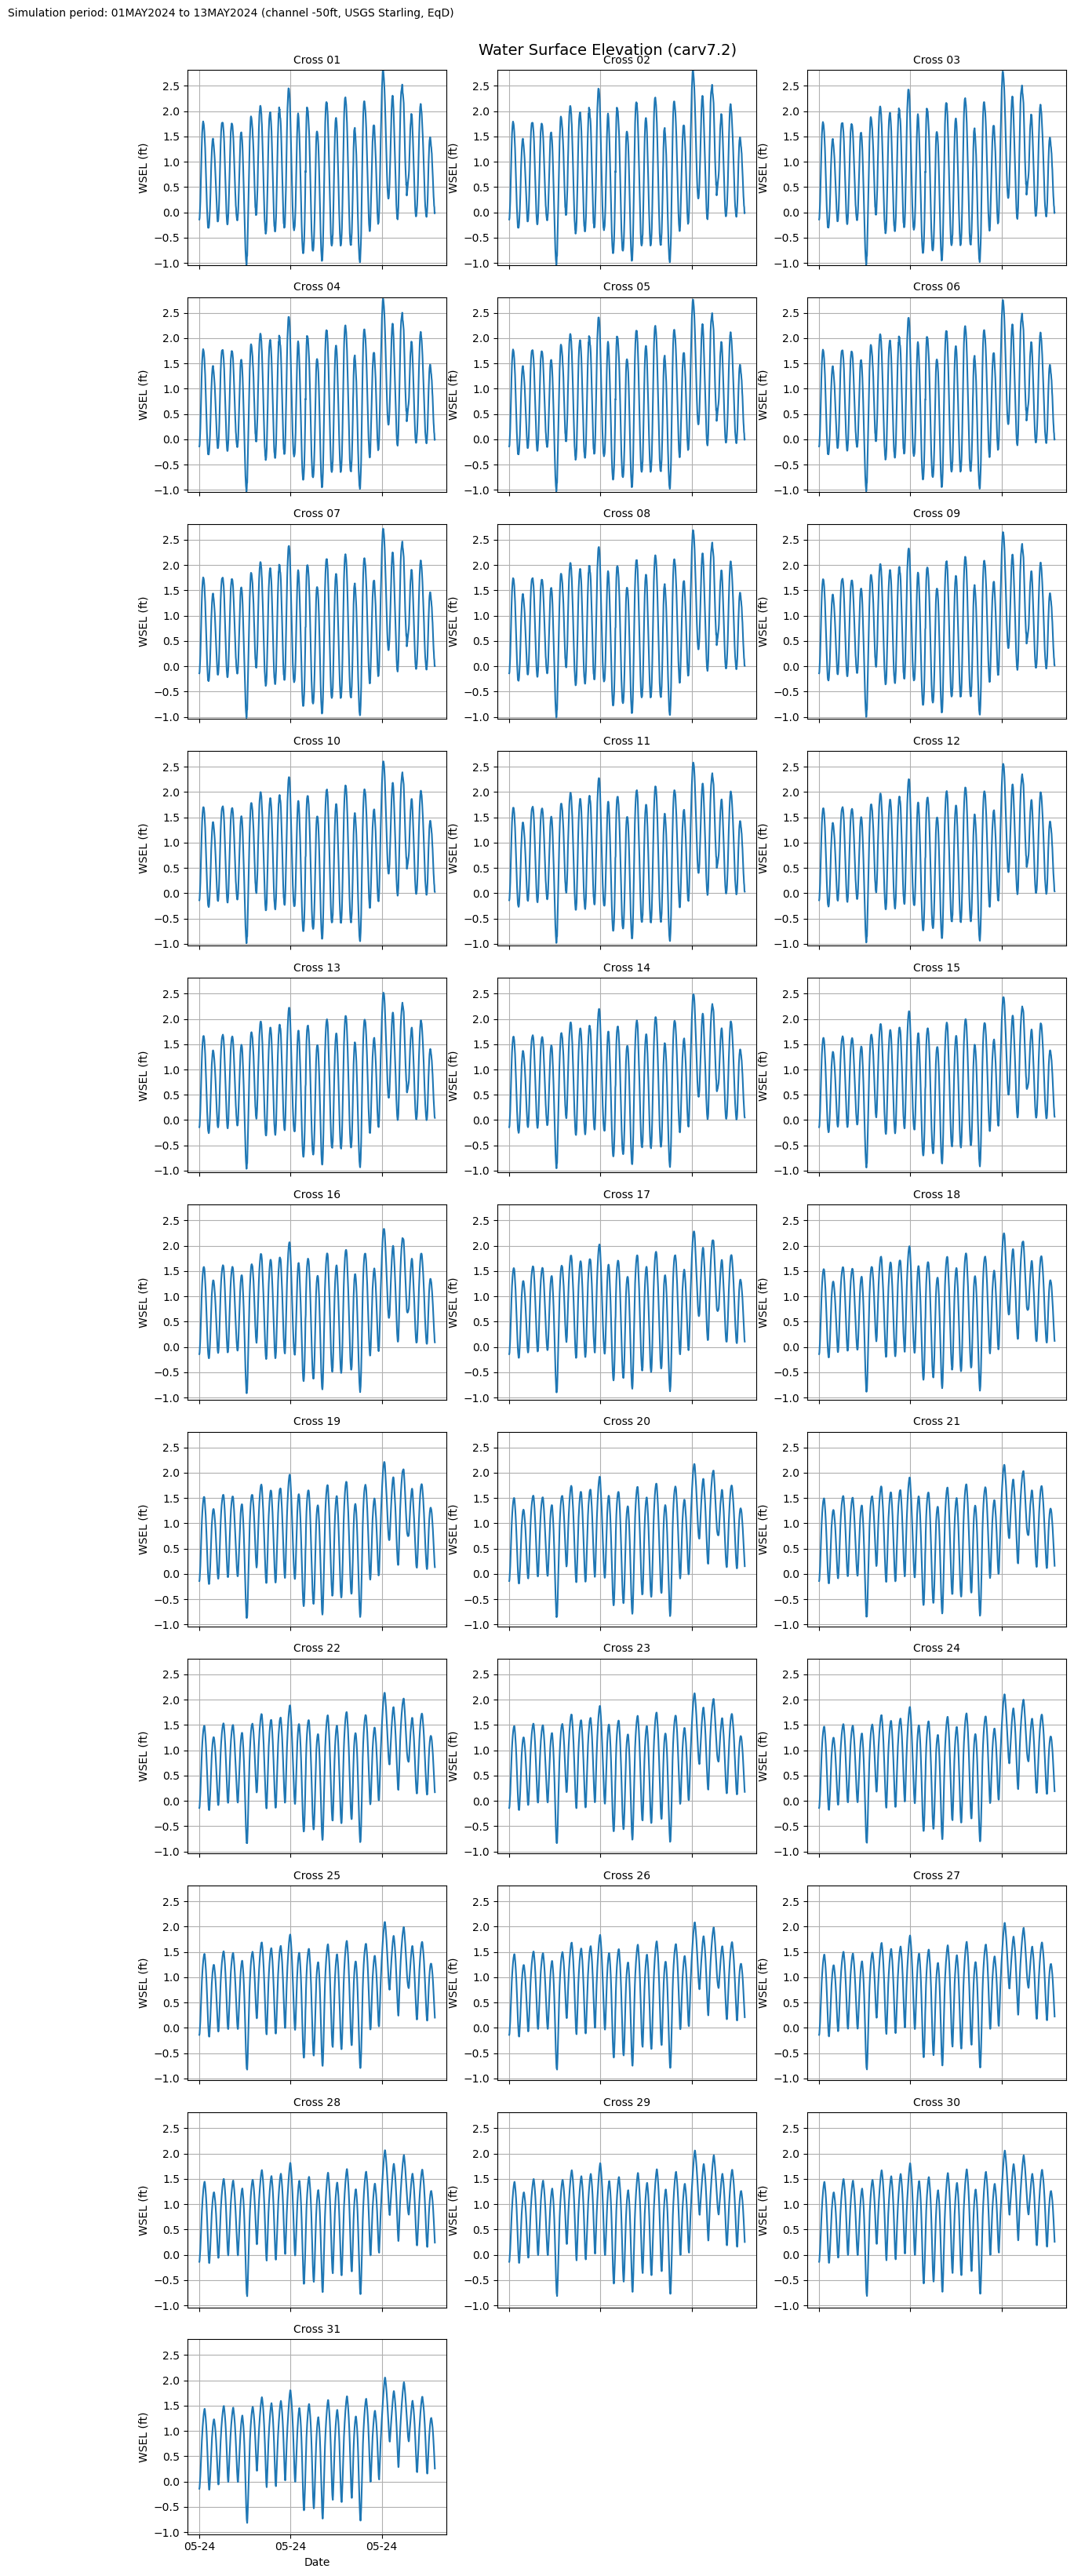

In [20]:
## Tides Simulation (WSEL)  (v5.p83) at 31 Cross Sections  (Carv7)
# === FILES INPUTS ===
hdf_path = r'C:\Github\Lab_work\Pocomoke\POCOMOKE_DEM\HDF\v5.p83.hdf' 
cell_ids = [628120, 627951, 627921, 628029, 627746, 627684, 627618, 627572, 627530, 627472, 627396, 627381,
            635980, 635128, 636050, 635000, 634940, 627311, 634847, 636360, 694557, 845840, 827923, 814408,
            660900, 647501, 634688, 634563, 636676, 627066, 634263]

# === OPEN HDF FILE ===
with h5py.File(hdf_path, 'r') as f:
    # 1. Get time info
    time_minutes = f['/Results/Unsteady/Output/Output Blocks/Base Output/Unsteady Time Series/Time'][:]
    start_str = f['/Results/Unsteady/Output/Output Blocks/Base Output/Unsteady Time Series/Time Date Stamp'][0].decode()
    start_datetime = datetime.strptime(start_str, '%d%b%Y %H:%M:%S')
    time_index = [start_datetime + timedelta(minutes=float(t)) for t in time_minutes]

    # 2. Get full water surface matrix (time_steps x num_cells)
    ws_all = f['/Results/Unsteady/Output/Output Blocks/Base Output/Unsteady Time Series/2D Flow Areas/VA20230620195713/Water Surface'][:]

    # 3. Get all cell minimum elevations (not used here but useful to keep)
    z_all = f['/Geometry/2D Flow Areas/VA20230620195713/Cells Minimum Elevation'][:]

    # 4. Build WSEL dataframe
    wsel_data = {}
    for cid in cell_ids:
        ws = ws_all[:, cid]
        wsel_data[f'Cell_{cid}'] = ws

# === CREATE FINAL DATAFRAME ===
wsel_df = pd.DataFrame(wsel_data, index=pd.to_datetime(time_index))
wsel_df.index.name = 'Datetime'

# === Mapping Cell ID → Cross Section Name ===
cell_to_cross = {
    628120: "Cross 01", 627951: "Cross 02", 627921: "Cross 03", 628029: "Cross 04", 627746: "Cross 05",
    627684: "Cross 06", 627618: "Cross 07", 627572: "Cross 08", 627530: "Cross 09", 627472: "Cross 10",
    627396: "Cross 11", 627381: "Cross 12", 635980: "Cross 13", 635128: "Cross 14", 636050: "Cross 15",
    635000: "Cross 16", 634940: "Cross 17", 627311: "Cross 18", 634847: "Cross 19", 636360: "Cross 20",
    694557: "Cross 21", 845840: "Cross 22", 827923: "Cross 23", 814408: "Cross 24", 660900: "Cross 25",
    647501: "Cross 26", 634688: "Cross 27", 634563: "Cross 28", 636676: "Cross 29", 627066: "Cross 30",
    634263: "Cross 31"
}

# === GLOBAL Y-AXIS RANGE ===
global_min = wsel_df.min().min()
global_max = wsel_df.max().max()

# === Prepare Grid ===
num_cells = len(wsel_df.columns)
cols = 3
rows = math.ceil(num_cells / cols)

fig, axes = plt.subplots(rows, cols, figsize=(cols * 4, rows * 3), sharex=True)
axes = axes.flatten()

# === Plot with Fixed Y-axis ===
for i, col in enumerate(wsel_df.columns):
    cell_id = int(col.replace("Cell_", ""))
    cross_name = cell_to_cross.get(cell_id, col)

    ax = axes[i]
    ax.plot(wsel_df.index, wsel_df[col])
    ax.set_title(cross_name, fontsize=10)
    ax.set_ylabel("WSEL (ft)")
    ax.set_ylim(global_min, global_max)
    ax.grid(True)

    ax.xaxis.set_major_locator(mdates.AutoDateLocator())
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%m-%y'))

    if i >= (rows - 1) * cols:
        ax.set_xlabel("Date")

# === Remove Unused Subplots ===
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

# === Figure Title and Layout ===
fig.suptitle("Water Surface Elevation (carv7.2)", fontsize=14)
fig.text(0.1, 0.99, "Simulation period: 01MAY2024 to 13MAY2024 (channel -50ft, USGS Starling, EqD)", ha='center', fontsize=10)
plt.tight_layout(rect=[0, 0, 1, 0.99])
plt.show()

# === Optional: Save to CSV ===
# wsel_df.to_csv('7wsel_cells.csv')
# print("Saved: 7wsel_cells.csv")

#Compare model results and Shelltown gauge

-Reference: between cross 2 and 3

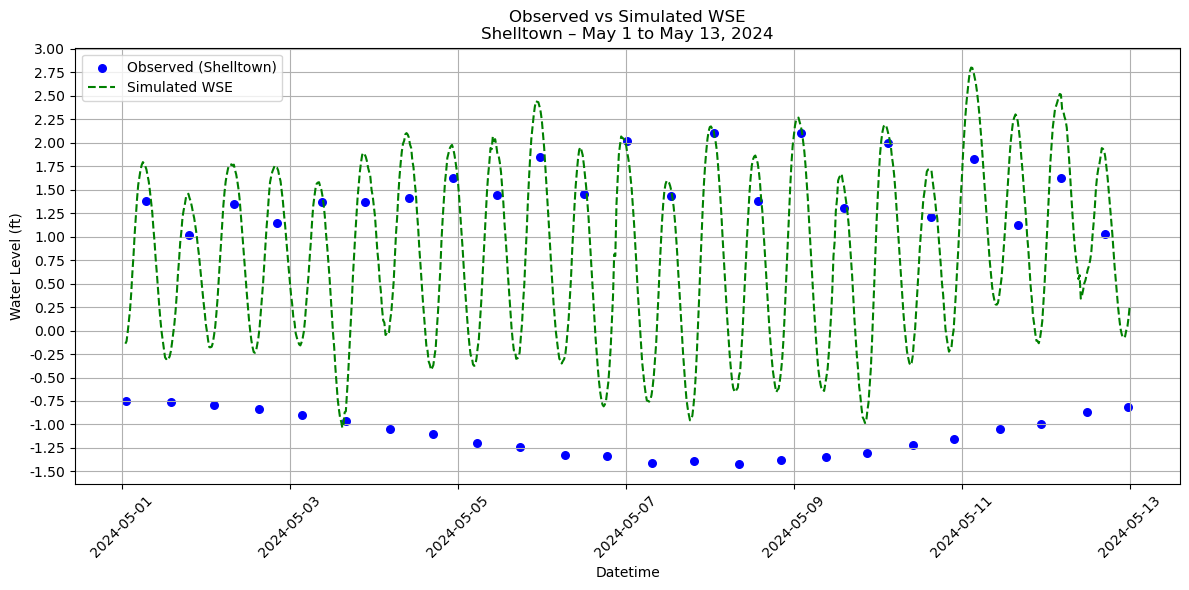

In [22]:
#Plot close to Shelltown, MD Gauge Data needs to be updated v5.p83.hdf' - carv7

# === Load Excel files ===
file_obs = r"C:\Github\Lab_work\Pocomoke\POCOMOKE_DEM\Depth_2024\BookShellfinal.xlsx"
file_sim = r"C:\Github\Lab_work\Pocomoke\POCOMOKE_DEM\Depth_2024\USGS_gage_closeShel_v8.xlsx"

# === Read Excel files ===
df_obs = pd.read_excel(file_obs)
df_sim = pd.read_excel(file_sim)

# === Clean column names ===
df_obs.columns = df_obs.columns.str.strip()
df_sim.columns = df_sim.columns.str.strip()

# === Create datetime columns ===
df_obs['Datetime'] = pd.to_datetime(df_obs['Date'].astype(str) + ' ' + df_obs['Time'].astype(str))
df_sim['Datetime'] = pd.to_datetime(df_sim['Time'])

# === Filter date range: May 1–13, 2024 ===
start_date = pd.to_datetime("2024-05-01")
end_date = pd.to_datetime("2024-05-13")

df_obs_filtered = df_obs[(df_obs['Datetime'] >= start_date) & (df_obs['Datetime'] <= end_date)]
df_sim_filtered = df_sim[(df_sim['Datetime'] >= start_date) & (df_sim['Datetime'] <= end_date)]

# === Define Y-axis ticks with 0.25 intervals ===
y_min = min(df_obs_filtered['Predicted (ft)(NAV)'].min(), df_sim_filtered['WSE (feet)'].min()) - 0.05
y_max = max(df_obs_filtered['Predicted (ft)(NAV)'].max(), df_sim_filtered['WSE (feet)'].max()) + 0.05
yticks = np.arange(np.floor(y_min * 4) / 4, np.ceil(y_max * 4) / 4 + 0.25, 0.25)

# === Plot overlay ===
plt.figure(figsize=(12, 6))

# Plot observed as points only
plt.scatter(df_obs_filtered['Datetime'], df_obs_filtered['Predicted (ft)(NAV)'],
            label='Observed (Shelltown)', color='blue', marker='o', s=30)

# Plot simulated as continuous dashed line
plt.plot(df_sim_filtered['Datetime'], df_sim_filtered['WSE (feet)'],
         label='Simulated WSE', color='green', linestyle='--')

# Apply Y-ticks
plt.yticks(yticks, [f"{tick:.2f}" for tick in yticks])

# Formatting
plt.title('Observed vs Simulated WSE\nShelltown – May 1 to May 13, 2024')
plt.xlabel('Datetime')
plt.ylabel('Water Level (ft)')
plt.xticks(rotation=45)
plt.grid(True)
plt.legend()
plt.tight_layout()

# === Show plot
plt.show()

#Compare model results and Snow Hill gauge
    
    -Reference cross 31

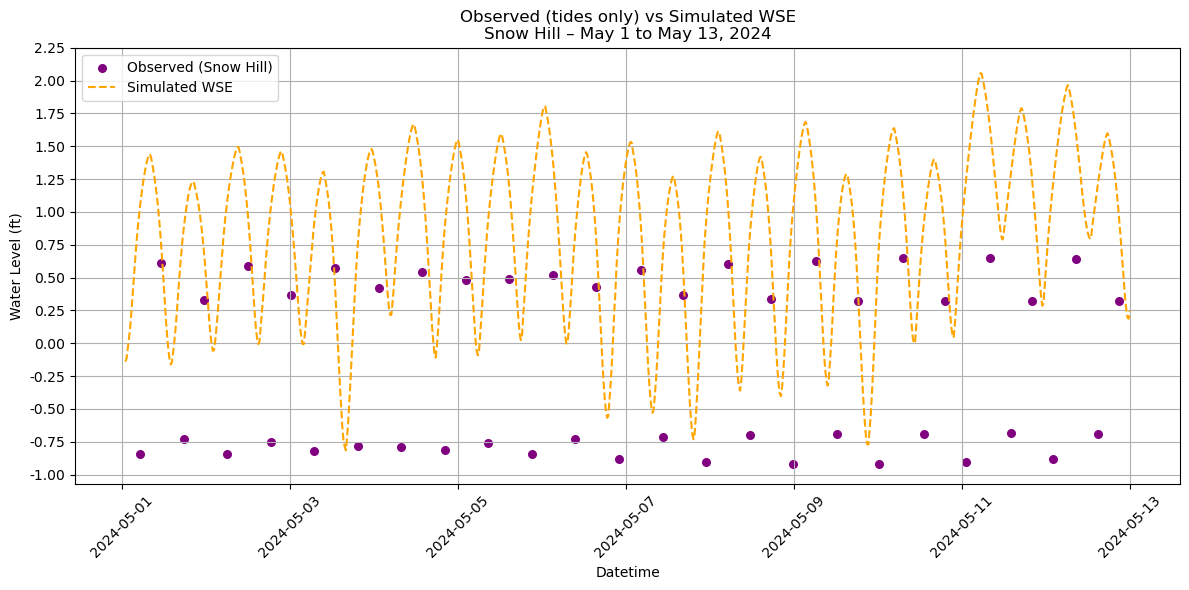

In [21]:
# === Load Excel files
file_obs = r"C:\Github\Lab_work\Pocomoke\POCOMOKE_DEM\Depth_2024\Book_Snowhill.xlsx"
file_sim = r"C:\Github\Lab_work\Pocomoke\POCOMOKE_DEM\Depth_2024\USGS_closesnow_vs7 (v5.p83).xlsx" #  (v5.p82)

# === Read data
df_obs = pd.read_excel(file_obs)
df_sim = pd.read_excel(file_sim)

# === Clean column names
df_obs.columns = df_obs.columns.str.strip()
df_sim.columns = df_sim.columns.str.strip()

# === Create datetime columns
df_obs['Datetime'] = pd.to_datetime(df_obs['Date'].astype(str) + ' ' + df_obs['Time'].astype(str))
df_sim['Datetime'] = pd.to_datetime(df_sim['Datetime'])

# === Filter date range: May 1–13, 2024
start_date = pd.to_datetime("2024-05-01")
end_date = pd.to_datetime("2024-05-13")

df_obs_filtered = df_obs[(df_obs['Datetime'] >= start_date) & (df_obs['Datetime'] <= end_date)]
df_sim_filtered = df_sim[(df_sim['Datetime'] >= start_date) & (df_sim['Datetime'] <= end_date)]

# === Plot overlay
plt.figure(figsize=(12, 6))

# Plot observed as points only (no connecting lines)
plt.scatter(df_obs_filtered['Datetime'], df_obs_filtered['Tides_obs (ft)'],
            label='Observed (Snow Hill)', color='purple', marker='o', s=30)

# Plot simulated as continuous dashed line
plt.plot(df_sim_filtered['Datetime'], df_sim_filtered['WSE (feet)'],
         label='Simulated WSE', color='orange', linestyle='--')

# === Custom Y-axis ticks
yticks = np.arange(-1.00, 2.50, 0.25)
plt.yticks(yticks, [f"{tick:.2f}" for tick in yticks])

# === Plot formatting
plt.title('Observed (tides only) vs Simulated WSE\nSnow Hill – May 1 to May 13, 2024')
plt.xlabel('Datetime')
plt.ylabel('Water Level (ft)')
plt.xticks(rotation=45)
plt.grid(True)
plt.legend()
plt.tight_layout()

# === Show plot
plt.show()